# Imports

In [1]:
import os                                   # Find files in subdirectory 
import nrrd                                 # Work with NRRD files 
import random                               # Generate random numbers
import numpy as np                          # General work with arrays
import matplotlib.pyplot as plt             # Plotting
from mpl_toolkits import mplot3d            # 3D Plotting
from pyquaternion import Quaternion         # Rotate a set of xyz coordinates
import math                                 # Generate Pi
import time                                 # Timestamp creation
import datetime                             # Formatting Timestamps
import sys                                  # Flush sytem printouts

# Custom Functions

In [2]:
''''Set a theshold. Based on this threshold the 3D array is converted to a binary 
array of ones and zeros. Then the 3D Array is converted to an array of the xyz 
coordinates specifying the location of all ones within the array' '''

def Tresh(Treshold_Setting, Treshold, Array):
    if Treshold_Setting == 'less than':
        Array = np.where(Array<Treshold)
    if Treshold_Setting == 'greater than':
        Array = np.where(Array>Treshold)
    
    Array_ = np.zeros((len(Array[0]),3),dtype=int)
    Array_[:,0] = Array[0]
    Array_[:,1] = Array[1]
    Array_[:,2] = Array[2]   
    return Array_

In [3]:
'''' Resample an array of xyz coordinates so as to create a point cloud 
of desired size' '''

def resample(Array, sample_size, noise):
    Selection = np.random.choice(Array.shape[0], size=sample_size)
    Array = Array[Selection]
    Noise = (np.random.uniform(low=-1, high=1, 
                               size=(Array.shape[0],
                                     Array.shape[1])))*noise
    result = Array + Noise
    return result

In [4]:
'''' Resize an array of xyz coordinates by random ammounts (within 
defigned variation limits). Variation must be specifed as a number 
between 0 and 1. This represents the maximum percentage that the array 
can be stretched/squeezed in any direction' '''

def resize(Array, Variation):
    ResizeArray = np.random.uniform(low=1-(0.5*Variation), 
                                    high=1+(0.5*Variation), 
                                    size=(Array.shape[1]))
    
    result = Array*ResizeArray
    return result

In [5]:
'''' This function scales array of vectors to the desired size' '''

def Scale(Array, size):
        # Ensure that all vectors are positive
        if Array[:,0].min()<0:
            Array[:,0] = Array[:,0] - Array[:,0].min()
        
        if Array[:,1].min()<0:
            Array[:,1] = Array[:,1] - Array[:,1].min()
        
        if Array[:,2].min()<0:
            Array[:,2] = Array[:,2] - Array[:,2].min()
        
        #Expand the array such that it will fit within a cube of defined "size"  
        Array = ((size)/(Array.max()))*Array
        return Array

In [6]:
""""Rotate an array of xyz coordinates about an axis through a defigned angle. 
For more details on the library used refer to - http://kieranwynn.github.io/pyquaternion/
The rotation axis is created with two points. The first is always assumed to be 
[0,0,0] and the second must be specified.
The ammount of rotation ('theta') must be defigned in radians" """

def Rotate(Array, axis, theta):
    for i in range (Array.shape[0]):
        Array[i] = Quaternion(axis=axis,angle=theta).rotate(Array[i])
    return Array

# Dataset Generation

In [7]:
# Specify required variables
dataset_size = 3000 # Number of samples to be generated
array_cube_size = 50 # Cube size (that the 3D model must fit within)  
PointCloudSize = 55000 # Quantity of points sampled over the surface of the 3D model
path = 'training' # Name of folder in working directory where NRRD files are stored  

In [8]:
Training = np.empty((0, 3*PointCloudSize)) # initiate a numpy array to hold generated data 
t = time.process_time() # Step start time

fail = [] # initiate list to be filled with names of any NRRD files that fail to open
files = [f for f in os.listdir(path) if f.endswith('.nrrd')] # Create a list of all the NRRD files available

for i in range(dataset_size):
    while True: # Ensures that if there is an NRRD file which fails to open this step wont fail
        try:
            selection = random.randint(1,(len(files)-1))
            data_path = path + '/'+files[selection]
            NRRD, header = nrrd.read(data_path)
            Array3D = Tresh('greater than', 200, NRRD)
            Array3D = resample(Array3D, PointCloudSize, 3)
        
        except:
            fail.append(files[selection]) # add name of any file that failed to open to a list
            continue
        break   
    
    # The RotVecs function can be time intensive for high dataset_size or PointCloudSize. 
    # If not required the following function can be deleted to expedite run time
    Array3D = Rotate(Array3D, [random.uniform(0, 1),
                                random.uniform(0, 1),
                                random.uniform(0, 1)], 
                      random.uniform(0, math.pi))
    
    Array3D = resize(Array3D, .4)
    Array3D = Scale(Array3D, array_cube_size) 
    combined = np.concatenate((Array3D[:,0],Array3D[:,1],Array3D[:,2]), axis = 0) 
    Training = np.append(Training, [combined], axis=0) 
    
    PercentCompletion = ((((i+1)/dataset_size)*100)) # Calculate percatage data already generated
    elapsed_time = time.process_time() - t # Calculate total runtime
    RemainingTime = int((elapsed_time/PercentCompletion)*(100-PercentCompletion)) # Estimate time remaining
    
    #Print out Status Updates
    sys.stdout.flush() 
    print("\r" +"Percent Completion:" + str(int(PercentCompletion))+'%'
          +'   '+'Time Remaining Estimate (hrs:min:sec): '+str(datetime.timedelta(seconds=RemainingTime)), end='')

#Print out to total run time upon completion
print("\n" + "Completed! Total Run Time (minutes): " +str(int(elapsed_time/60)))

# If any of the NRRD files could not be opened print out their names so that the issue can be root caused
if len(fail)>0:
    fail = list(set(fail))
    print("\n" + "The following files could not be opened: ")
    for i in fail:
        print("\n" + i)

Percent Completion:100%   Time Remaining Estimate (hrs:min:sec): 0:00:00
Completed! Total Run Time (minutes): 444


# Plot some samples from the Generated Dataset

In [14]:
# Specify the required variables
Samples = 5 # Specify how many samples to plot 
Color = 'red' # Set the color to plot the point cloud in
Alpha = 0.1 # Set transparency of each point plotted
size = 0.2 #Set the size of each point plotted

ID of Selection Plotted: 1265


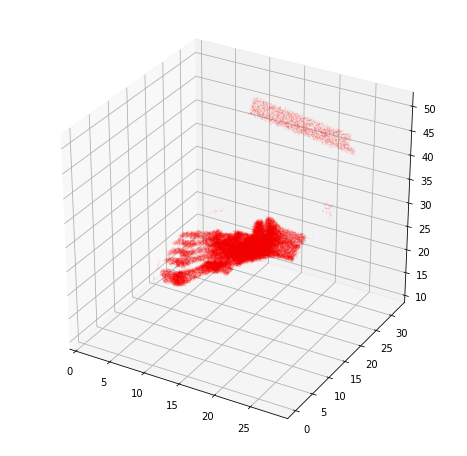

ID of Selection Plotted: 91


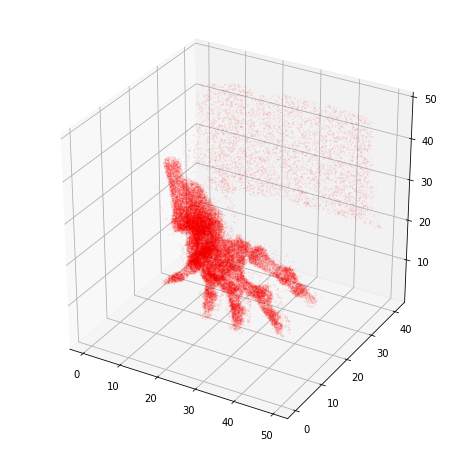

ID of Selection Plotted: 2581


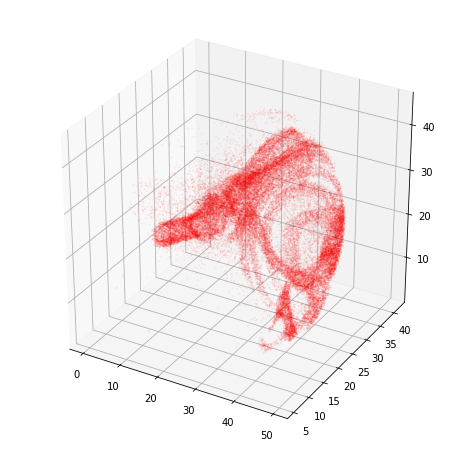

ID of Selection Plotted: 2853


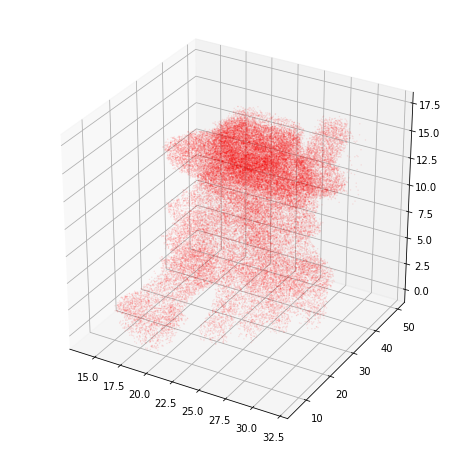

ID of Selection Plotted: 1136


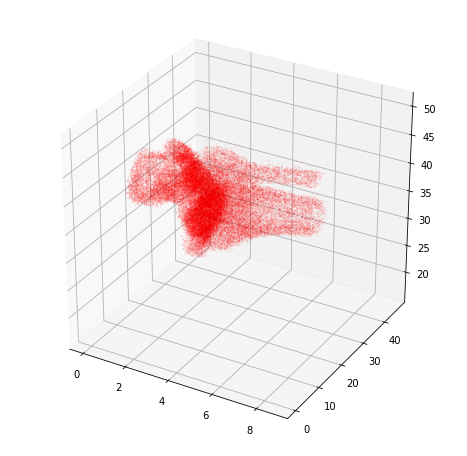

In [15]:
for i in range(Samples):
    Random_Selection = np.random.randint((Training.shape[0]),size=1)[0]
    
    X = Training[Random_Selection,:PointCloudSize]
    Y = Training[Random_Selection,PointCloudSize:PointCloudSize*2]
    Z = Training[Random_Selection,PointCloudSize*2:PointCloudSize*3]
    
    print('ID of Selection Plotted: '+ str(Random_Selection))
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, zdir='z', c= Color, alpha=Alpha, s=size)
    plt.show()

# Save the Generated Dataset to a CSV file

In [11]:
np.savetxt("GeneratedData.csv", Training , delimiter=",")